In [1]:
import sys
from pathlib import Path
from typing import Any, Callable

import dotenv
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchmetrics.classification
import torchmetrics.segmentation
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar
from simplecv.module import fpn
from torch import Tensor

from inz.data.data_module import XBDDataModule
from inz.data.event import Event, Hold, Test, Tier1, Tier3
from inz.util import get_wandb_logger, show_masks_comparison

sys.path.append("inz/farseg")

from inz.models.farseg_module import DoubleBranchFarSegModule, DoubleBranchFarSeg

In [2]:
dotenv.load_dotenv()
RANDOM_SEED = 123
pl.seed_everything(RANDOM_SEED)
device = torch.device("cuda")
torch.set_float32_matmul_precision("high")

Seed set to 123


In [3]:
BATCH_SIZE = 80

dm = XBDDataModule(
    path=Path("data/xBD_processed"),
    drop_unclassified_channel=True,
    # split_events={
    #     "train": {
    #         Tier1: [
    #             Event.guatemala_volcano,
    #             Event.hurricane_florence,
    #             Event.hurricane_harvey,
    #             Event.hurricane_matthew,
    #             Event.hurricane_michael,
    #             Event.mexico_earthquake,
    #             Event.midwest_flooding,
    #             Event.palu_tsunami,
    #             Event.santa_rosa_wildfire,
    #             Event.socal_fire,
    #         ],
    #         Tier3: [
    #             Event.joplin_tornado,
    #             Event.lower_puna_volcano,
    #             Event.moore_tornado,
    #             Event.nepal_flooding,
    #             Event.pinery_bushfire,
    #             Event.portugal_wildfire,
    #             Event.sunda_tsunami,
    #             Event.tuscaloosa_tornado,
    #             Event.woolsey_fire,
    #         ],
    #         Test: [
    #             Event.guatemala_volcano,
    #             Event.hurricane_florence,
    #             Event.hurricane_harvey,
    #             Event.hurricane_matthew,
    #             Event.hurricane_michael,
    #             Event.mexico_earthquake,
    #             Event.midwest_flooding,
    #             Event.palu_tsunami,
    #             Event.santa_rosa_wildfire,
    #             Event.socal_fire,
    #         ]
    #     },
    #     "val": {
    #         Hold: [
    #             Event.guatemala_volcano,
    #             Event.hurricane_florence,
    #             Event.hurricane_harvey,
    #             Event.hurricane_matthew,
    #             Event.hurricane_michael,
    #             Event.mexico_earthquake,
    #             Event.midwest_flooding,
    #             Event.palu_tsunami,
    #             Event.santa_rosa_wildfire,
    #             Event.socal_fire,
    #         ]
    #     }
    # },
    events={
        Tier1: [
            Event.hurricane_harvey,
            Event.hurricane_michael,
            Event.mexico_earthquake,
            Event.santa_rosa_wildfire,
            Event.socal_fire,
        ],
        Tier3: [
            Event.joplin_tornado,
            Event.moore_tornado,
            Event.nepal_flooding,
            Event.pinery_bushfire,
        ],
        Hold: [
            Event.hurricane_harvey,
            Event.midwest_flooding,
            Event.mexico_earthquake,
        ]
    },
    val_fraction=0.15,
    test_fraction=0.,
    train_batch_size=BATCH_SIZE,
    val_batch_size=BATCH_SIZE,
    test_batch_size=BATCH_SIZE,
)
dm.prepare_data()
dm.setup("fit")

print(f"{len(dm.train_dataloader())} train batches, {len(dm.val_dataloader())} val batches")

62 train batches, 11 val batches


In [4]:
config = dict(
    resnet_encoder=dict(
        resnet_type="resnet50",
        include_conv5=True,
        batchnorm_trainable=True,
        pretrained=True,
        freeze_at=0,
        # 8, 16 or 32
        output_stride=32,
        with_cp=(False, False, False, False),
        stem3_3x3=False,
    ),
    fpn=dict(
        in_channels_list=(512, 1024, 2048, 4096),
        # in_channels_list=(256, 512, 1024, 2048),
        out_channels=256,
        conv_block=fpn.default_conv_block,
        top_blocks=None,
    ),
    scene_relation=dict(
        in_channels=4096,
        # in_channels=2048,
        channel_list=(256, 256, 256, 256),
        out_channels=256,
        scale_aware_proj=True,
    ),
    decoder=dict(
        in_channels=256,
        out_channels=128,
        in_feat_output_strides=(4, 8, 16, 32),
        out_feat_output_stride=4,
        norm_fn=nn.BatchNorm2d,
        num_groups_gn=None,
    ),
    num_classes=5,
    loss=dict(
        cls_weight=1.0,
        ignore_index=255,
    ),
    annealing_softmax_focalloss=dict(gamma=2.0, max_step=len(dm.train_dataloader()) * BATCH_SIZE, annealing_type="cosine"),
)

In [5]:
# class_weights = None
class_weights = torch.Tensor([0.01, 1, 9.04788032, 8.68207691, 12.9632271]).to(device)
model = DoubleBranchFarSegModule(
    model=DoubleBranchFarSeg(farseg_config=config, n_classes=5, class_weights=class_weights).to(device),
    class_weights=class_weights,
    optimizer_factory=lambda params: torch.optim.AdamW(params, lr=0.0002, weight_decay=1e-4),
    # optimizer_factory=lambda params: torch.optim.SGD(params, momentum=0.9, weight_decay=1e-4),
    scheduler_factory=lambda optimizer: torch.optim.lr_scheduler.PolynomialLR(
        optimizer=optimizer, power=0.9, total_iters=len(dm.train_dataloader()) * BATCH_SIZE
    ),
).to(device)

INFO:simplecv.util.logger:ResNetEncoder: pretrained = True


scene_relation: on
loss type: cosine


In [6]:
wandb_logger = get_wandb_logger(run_name="Delete me")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tomasz-owienko-stud (tomasz-owienko-stud-warsaw-university-of-technology). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/tomek/.netrc


In [7]:
trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[
        RichProgressBar(),
        ModelCheckpoint(
            dirpath="delete_me",
            save_last="link",
            save_top_k=1,
            monitor="epoch",
            mode="max",
            filename="farseg_test_original_split-{epoch:02d}-{step:03d}-{f1:.6f}-last"
        ),
        ModelCheckpoint(
            dirpath="delete_me",
            save_last="link",
            save_top_k=2,
            monitor="f1",
            mode="max",
            filename="farseg_test_original_split-{epoch:02d}-{step:03d}-{f1:.6f}-best-f1"
        ),
        ModelCheckpoint(
            dirpath="delete_me",
            save_last="link",
            save_top_k=2,
            monitor="val_loss",
            mode="min",
            filename="farseg_test_original_split-{epoch:02d}-{step:03d}-{f1:.6f}-best-val-loss"
        )
    ],
    precision="bf16",
    logger=wandb_logger,
)
trainer.fit(model, datamodule=dm)

/home/tomek/inz/inz/.venv/lib/python3.11/site-packages/lightning_fabric/connector.py:563: `precision=bf16` is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tomek/inz/inz/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:44: attribute 'optimizer_factory' removed from hparams because it cannot be pickled
/home/tomek/inz/inz/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:44: attribute 'scheduler_factory' removed from hparams because it cannot be pickled


/home/tomek/inz/inz/.venv/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/tomek/inz/inz/delete_me exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                ┃ Type                ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ model               │ DoubleBranchFarSeg  │ 34.5 M │
│ 1  │ accuracy_loc        │ BinaryAccuracy      │      0 │
│ 2  │ iou_loc             │ MeanIoU             │      0 │
│ 3  │ f1                  │ MulticlassF1Score   │      0 │
│ 4  │ precision           │ MulticlassPrecision │      0 │
│ 5  │ recall              │ MulticlassRecall    │      0 │
│ 6  │ iou                 │ MeanIoU             │      0 │
│ 7  │ f1_per_class        │ MulticlassF1Score   │      0 │
│ 8  │ precision_per_class │ MulticlassPrecision │      0 │
│ 9  │ recall_per_class    │ MulticlassRecall    │      0 │
│ 10 │ iou_per_class       │ MeanIoU             │      0 │
│ 11 │ f1_loc              │ BinaryF1Score       │      0 │
└────┴─────────────────────┴─────────────────────┴────────┘

Trainable params: 34.5 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 34.5 M                                                                                               
Total estimated model params size (MB): 137

Output()

/home/tomek/inz/inz/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected 
KeyboardInterrupt, attempting graceful shutdown...

In [ ]:
model.eval()

DoubleBranchFarSegModule(
  (model): DoubleBranchFarSeg(
    (module): FarSeg(
      (en): ResNetEncoder(
        (resnet): ResNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       

In [ ]:
it = iter(dm.val_dataloader())


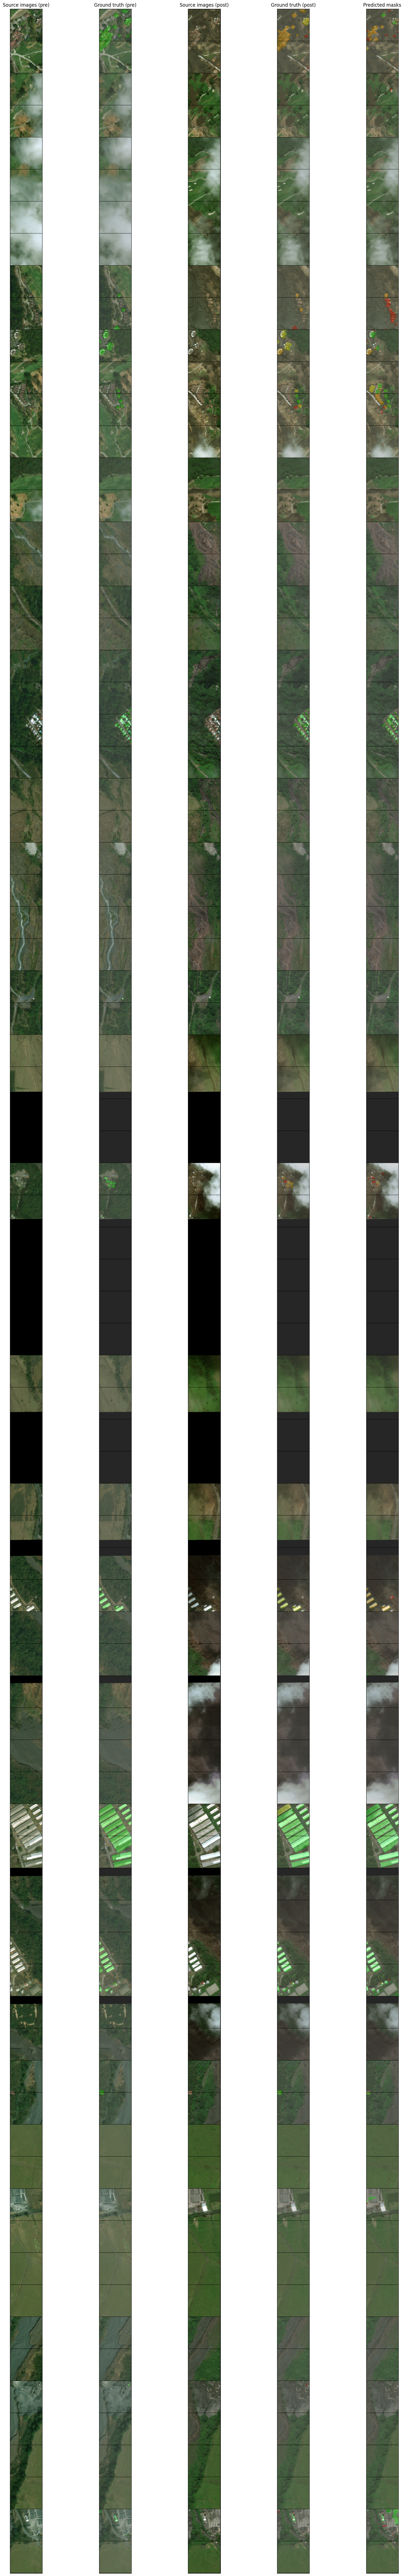

In [ ]:
batch = next(it)
images_pre, masks_pre, images_post, masks_post = batch
with torch.no_grad():
    m = model.to(device)
    preds = m(torch.cat([images_pre, images_post], dim=1).to(device))

plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["figure.figsize"] = [20, 120]

show_masks_comparison(
    images_pre=images_pre, images_post=images_post, masks_pre=masks_pre, masks_post=masks_post, preds=preds, opacity=0.3
)